<h2>第1章</h2>

色々な正規分布を出力する

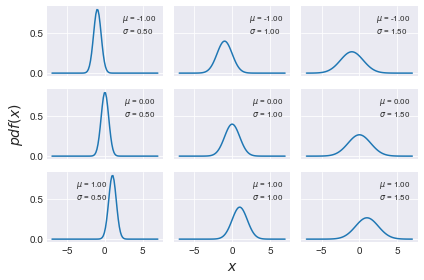

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
plt.style.use('seaborn-darkgrid')

# μ、σは既知である前提
mu_params = [-1, 0, 1]
sd_params = [0.5, 1, 1.5]
x = np.linspace(-7, 7, 100)
f, ax = plt.subplots(len(mu_params), len(sd_params), sharex=True, sharey=True)

for i in range(3):
    for j in range(3):
        mu = mu_params[i]
        sd = sd_params[j]
        y = stats.norm(mu, sd).pdf(x)
        ax[i, j].plot(x, y)
        ax[i, j].plot(0, 0, label="$\\mu$ = {:3.2f}\n$\\sigma$ = {:3.2f}".format(mu, sd), alpha=0)  #$(ドル)マークで囲むと、tex形式で表現可能
        ax[i, j].legend(fontsize=8)
    ax[2, 1].set_xlabel('$x$', fontsize=14)
    ax[1, 0].set_ylabel('$pdf(x)$', fontsize=14)
    plt.tight_layout()
#    plt.show()

時系列データを例示する

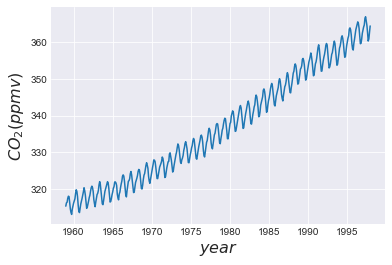

In [2]:
data = np.genfromtxt('mauna_loa_CO2.csv', delimiter=',')
plt.plot(data[:,0], data[:,1])
plt.xlabel('$year$', fontsize=16)
plt.ylabel('$CO_2 (ppmv)$', fontsize=16)
plt.show()

様々な二項分布を出力する

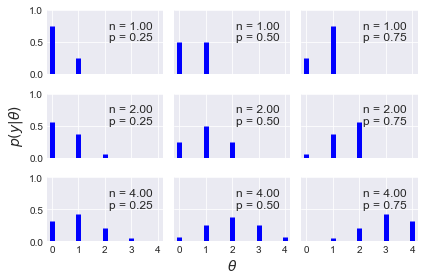

In [3]:
n_params = [1, 2, 4]
p_params = [0.25, 0.5, 0.75]
x = np.arange(0, max(n_params)+1)
f, ax = plt.subplots(len(n_params), len(p_params), sharex=True, sharey=True)

for i in range(3):
    for j in range(3):
        n = n_params[i]
        p = p_params[j]
        y = stats.binom(n=n, p=p).pmf(x)  # 二項分布の確率質量関数 https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html
        ax[i, j].vlines(x, 0, y, colors='b', lw=5)
        ax[i, j].set_ylim(0,1)
        ax[i, j].plot(0, 0, label="n = {:3.2f}\np = {:3.2f}".format(n,p), alpha=0)
        ax[i, j].legend(fontsize=12)
    
    ax[2, 1].set_xlabel('$\\theta$', fontsize=14)
    ax[1, 0].set_ylabel('$p(y|\\theta)$', fontsize=14)
    ax[0, 0].set_xticks(x)
    plt.tight_layout()

様々なベータ分布を出力する

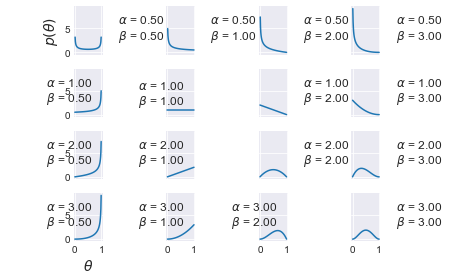

In [4]:
params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x)  # ベータ分布 https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html
        ax[i, j].plot(x, y)
        ax[i, j].plot(0, 0, label="$\\alpha$ = {:3.2f}\n$\\beta$ = {:3.2f}".format(a, b), alpha=0)
        ax[i, j].legend(fontsize=12)
        
    ax[3, 0].set_xlabel('$\\theta$', fontsize=14)
    ax[0, 0].set_ylabel('$p(\\theta)$', fontsize=14)
    plt.tight_layout()

事後分布を計算しグラフ化する

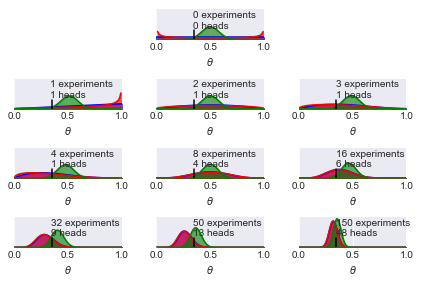

In [5]:
theta_real = 0.35
trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]

beta_params = [(1,1), (0.5,0.5), (20,20)]
dist = stats.beta  # 事前分布の設定
# 二項分布の事前分布にベータ分布を使用する理由
## 0と1の区間に制限されている
## パラメータによって様々な形をとる
## 2項分布の共役事前分布である

x = np.linspace(0, 1, 100)
for idx, N in enumerate(trials):
    if idx == 0:
        plt.subplot(4, 3, 2)
    else:
        plt.subplot(4, 3, idx+3)
    y = data[idx]
    for (a_prior, b_prior), c in zip(beta_params, ('b', 'r', 'g')):
        p_theta_given_y = dist.pdf(x, a_prior+y, b_prior+N-y)  # 事後分布の計算
        plt.plot(x, p_theta_given_y, c)
        plt.fill_between(x, 0, p_theta_given_y, color=c, alpha=0.6)
        
    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label="{:d} experiments\n{:d} heads".format(N, y), alpha=0)
    plt.xlim(0,1)
    plt.ylim(0,12)
    plt.xlabel(r'$\theta$')
    plt.legend()
    plt.gca().axes.get_yaxis().set_visible(False)
plt.tight_layout()

In [6]:
!pip install pymc3

https://gaiasky.hatenablog.com/entry/2018/08/17/083548

In [7]:
import pymc3 as pm
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.10.0


In [8]:
# 2枚のコインのデータを生成する。
n = 50 # コイン投げ回数
trials1 = stats.bernoulli.rvs(0.5, size=n)
trials2 = stats.bernoulli.rvs(0.55, size=n) #コイン2の方が表がちょっと出やすい。
h1 = sum(trials1)
h2 = sum(trials2)

# 最尤推定
print(h1/n, h2/n)

0.6 0.44


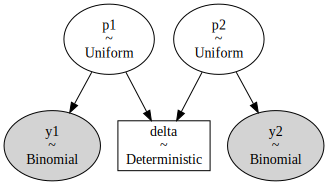

In [9]:
# Modelオブジェクトの生成
model = pm.Model()

# context managerの生成
with model:
    
    # 事前分布として一様分布を採用
    p1 = pm.Uniform('p1', lower=0.0, upper=1.0)
    p2 = pm.Uniform('p2', lower=0.0, upper=1.0)
    
    # 表がでる確率は二項分布から生成される
    y1 = pm.Binomial('y1', n=n, p=p1, observed=h1)
    y2 = pm.Binomial('y2', n=n, p=p2, observed=h2)
    
    # 2枚目のコインと1枚目のコインの表の出る確率の差を定義
    delta = pm.Deterministic('delta', p2-p1)

# Kruschkeのダイアグラム
pm.model_to_graphviz(model)

最高事後密度（単峰）を図示する

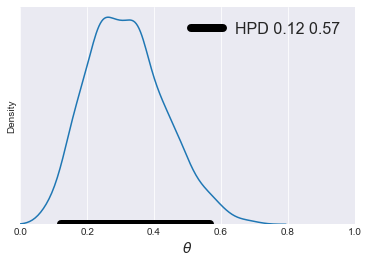

In [10]:
def naive_hpd(post):
    # カーネル密度推定をグラフ化
    sns.kdeplot(post)
    HPD = np.percentile(post, [2.5, 97.5])
    plt.plot(HPD, [0, 0], label='HPD {:.2f} {:.2f}'.format(*HPD), linewidth=8, color='k')
    plt.legend(fontsize=16)
    plt.xlabel(r'$\theta$', fontsize=14)
    # get the current axies  https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.gca.html
    plt.gca().axes.get_yaxis().set_ticks([])
    
np.random.seed(2)
# 1000個の乱数を生成
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html
post = stats.beta.rvs(5, 11, size=1000)
naive_hpd(post)
# x軸の範囲の設定
plt.xlim(0, 1)
plt.show()

2峰の最高事後密度区間を図示する

In [11]:
"""
This code was taken form the PyMC library https://github.com/pymc-devs/pymc
"""

import numpy as np

def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
        return np.array(calc_min_interval(sx, alpha))


In [12]:
from __future__ import division
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
#from hpd import hpd


def plot_post(param_sample_vec, cred_mass=0.95, comp_val=False,
              ROPE=False, ylab='', xlab='parameter', fontsize=14, labelsize=14,
              title='', framealpha=1, facecolor='skyblue', edgecolor='white',
              show_mode=True, bins=50):

    #compute HDI
    HDI = hpd(param_sample_vec, 1-cred_mass)

    post_summary = {'mean':0,'median':0,'mode':0, 'hdi_mass':0,'hdi_low':0,
                   'hdi_high':0, 'comp_val':0, 'pc_gt_comp_val':0, 'ROPE_low':0,
                   'ROPE_high':0, 'pc_in_ROPE':0}
    post_summary['mean'] = np.mean(param_sample_vec)
    post_summary['median'] = np.median(param_sample_vec)
    post_summary['mode'] = stats.mode(param_sample_vec)[0]
    post_summary['hdi_mass'] = cred_mass
    post_summary['hdi_low'] = HDI[0]
    post_summary['hdi_high'] = HDI[1]

    # Plot histogram.
    n, bins, patches = plt.hist(param_sample_vec, normed=True, bins=bins,
                                edgecolor=edgecolor, facecolor=facecolor)
    plt.xlabel(xlab, fontsize=fontsize)
    plt.ylabel(ylab, fontsize=fontsize)
    plt.title(title, fontsize=fontsize)

    cv_ht = 0.75*np.max(n)
    cen_tend_ht = 0.9 * cv_ht
    ROPE_text_ht = 0.55 * cv_ht
#    # Display mean or mode:
    if show_mode:
        plt.plot(0, label='mode = %.2f' % post_summary['mode'], alpha=0)
    else:
        plt.plot(0, label='mean = %.2f' % post_summary['mean'], alpha=0)
    # Display the comparison value.

    if comp_val is not False:
        pc_gt_comp_val = 100 * np.sum(param_sample_vec > comp_val)/len(param_sample_vec)
        pc_lt_comp_val = 100 - pc_gt_comp_val
        plt.plot([comp_val, comp_val], [0, cv_ht], color='darkgreen',
                 linestyle='--', linewidth=2,
                 label='%.1f%% <%.1f < %.1f%%'
                 % (pc_lt_comp_val, comp_val, pc_gt_comp_val))
        post_summary['comp_val'] = comp_val
        post_summary['pc_gt_comp_val'] = pc_gt_comp_val
#    # Display the ROPE.
    if ROPE is not False:
        rope_col = 'darkred'
        pc_in_ROPE = round(np.sum((param_sample_vec > ROPE[0]) & (param_sample_vec < ROPE[1]))/len(param_sample_vec)*100)
        plt.plot([ROPE[0], ROPE[0]], [0, 0.96*ROPE_text_ht], color=rope_col,
                linestyle=':', linewidth=4,
                label='%.1f%% in ROPE' % pc_in_ROPE)
        plt.plot([ROPE[1], ROPE[1]], [0, 0.96*ROPE_text_ht], color=rope_col,
                linestyle=':', linewidth=4)
        post_summary['ROPE_low'] = ROPE[0] 
        post_summary['ROPE_high'] = ROPE[1] 
        post_summary['pc_in_ROPE'] = pc_in_ROPE
#    # Display the HDI.
    plt.plot(HDI, [0, 0], linewidth=6, color='k', label='HDI %.1f%% %.3f-%.3f' % (cred_mass*100, HDI[0], HDI[1]))
    plt.legend(loc='upper left', fontsize=labelsize, framealpha=framealpha)
    frame = plt.gca()
    frame.axes.get_yaxis().set_ticks([])
    return post_summary

AttributeError: 'Rectangle' object has no property 'normed'

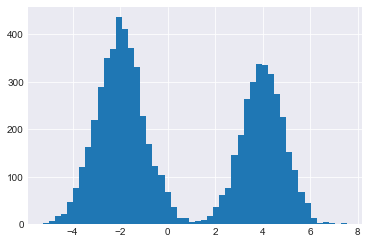

In [13]:
np.random.seed(1)
gauss_a = stats.norm.rvs(loc=4, scale=0.9, size=3000)
gauss_b = stats.norm.rvs(loc=-2, scale=1, size=4000)
mix_norm = np.concatenate((gauss_a, gauss_b))

#from plot_post import plot_post
plot_post(mix_norm, framealpha=0.05)
plt.legend(loc=0, fontsize=16)
plt.xlabel(r"$\theta$", fontsize=14)
plt.show()